In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from typing import Optional

from sklearn.model_selection import GridSearchCV, cross_val_score
from skopt import BayesSearchCV
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import networkx as nx

warnings.filterwarnings('ignore')


# Helping Functions

In [2]:
def create_encoder(df : pd.DataFrame, categorical_cols : list[str]) -> tuple[OneHotEncoder, list[str], list[dict[str, str]]]:
    """Creates an encoder for the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to create the encoder
        categorical_cols (list[str]): list of categorical columns

    Returns:
        tuple[OneHotEncoder, list[str], list[dict[str, str]]]: OneHotEncoder for categorical columns
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df[categorical_cols])
    encoded_feature_cols = encoder.get_feature_names_out(categorical_cols)
    feature_groups = []
    
    for col_1 in encoded_feature_cols:
        col_1_cat = col_1.rsplit('_', 1)[0]
        for cat in categorical_cols:
            if col_1_cat == cat and cat not in [group['variable'] for group in feature_groups]:
                feature_groups.append({'variable': cat, 'columns': [col_2 for col_2 in encoded_feature_cols if col_2.rsplit('_', 1)[0] == cat]})
                    
    return encoder, encoded_feature_cols, feature_groups
    

def one_hot_encode_df(df: pd.DataFrame, categorical_cols : list[str], encoder = OneHotEncoder) -> pd.DataFrame:
    """One hot encodes the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        categorical_cols (list[str]): columns to encode
        encoder (_type_, optional): en. Defaults to OneHotEncoder.

    Returns:
        pd.DataFrame: encoded dataframe
    """
    encoded =  encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(categorical_cols))
    df_oh = df.drop(categorical_cols, axis=1).join(encoded_df)
    return df_oh

def make_readable_encoded_column_names(df : pd.DataFrame, encoded_feature_cols : list[str], category_map) -> pd.DataFrame:
        """Renames the columns in a readable way based on the category_map"""
        readable_colnames = [] 
        for col in encoded_feature_cols:
            cat_name, cat_value = col.rsplit('_', 1)
            cat_value = int(cat_value)  
            if cat_name in category_map:
                if cat_value in category_map[cat_name]:
                    readable_colnames.append(f"{cat_name}_{category_map[cat_name][cat_value]}")
                else:
                    readable_colnames.append(col)
            else:
                readable_colnames.append(col)
        encoded_df = df[encoded_feature_cols]
        readable_encoded_df = pd.DataFrame(encoded_df.values, columns=readable_colnames)
        readable_df = df.drop(encoded_feature_cols, axis=1).join(readable_encoded_df)
        return readable_df

def fill_with_mode(df : pd.DataFrame, column : str) -> pd.DataFrame: 
    """Fills the missing values of the column with the mode of the column

    Args:
        df (pd.DataFrame): dataframe to fill
        column (str): column to fill

    Returns:
        pd.DataFrame: dataframe with filled column
    """
    mode = df[column].mode()[0]
    df[column] = df[column].fillna(mode)
    return df


## Read data from csv file

In [3]:
HEART_DATA = pd.read_csv('data/heart.csv')
print(f"Heart data shape: {HEART_DATA.shape}")

Heart data shape: (303, 14)


In [4]:
HEART_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Data descriptions: 

1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. ca - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

- Based on the data description, we can divide the columns into categorical feature columns and numerical feature columns. 
- We also define the Target column which we know is 'output'

In [5]:
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'] 
NUMERICAL_COLS = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
TARGET_COLUMN = 'output'

In [6]:
#Making a dictonary to be able to map the column-names of the encoded dataframe to more readable descriptive names
CATEGORY_MAP = {
    'sex': {0: 'female', 1: 'male'},
    'fbs': {0: '<=120mg/dl', 1: '>120mg/dl'},
    'restecg': {0: 'hypertrophy', 1: 'normal', 2: 'having_ST-T_wave_abnormality'},
    'cp': {0: 'asymptomatic', 1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal_pain'},
    'exng': {0: 'No', 1: 'Yes'},
    'slp': {0: 'downsloping', 1: 'flat', 2: 'upsloping'},
    'caa': {0: '0', 1: '1', 2: '2', 3: '3'},
    'thall': {1: 'fixed_defect', 2: 'normal', 3: 'reversible_defect'},
}

In [7]:
def make_readable_df(df : pd.DataFrame, category_map) -> pd.DataFrame:
    #Change the values in the dataframe to more readable values
    for column in df.columns:
        if column in category_map:
            df[column] = df[column].map(category_map[column])
    return df 

HEART_DATA_READABLE = make_readable_df(HEART_DATA.copy(), CATEGORY_MAP)
HEART_DATA_READABLE

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,male,non_anginal_pain,145,233,>120mg/dl,hypertrophy,150,No,2.3,downsloping,0,fixed_defect,1
1,37,male,atypical_angina,130,250,<=120mg/dl,normal,187,No,3.5,downsloping,0,normal,1
2,41,female,typical_angina,130,204,<=120mg/dl,hypertrophy,172,No,1.4,upsloping,0,normal,1
3,56,male,typical_angina,120,236,<=120mg/dl,normal,178,No,0.8,upsloping,0,normal,1
4,57,female,asymptomatic,120,354,<=120mg/dl,normal,163,Yes,0.6,upsloping,0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,female,asymptomatic,140,241,<=120mg/dl,normal,123,Yes,0.2,flat,0,reversible_defect,0
299,45,male,non_anginal_pain,110,264,<=120mg/dl,normal,132,No,1.2,flat,0,reversible_defect,0
300,68,male,asymptomatic,144,193,>120mg/dl,normal,141,No,3.4,flat,2,reversible_defect,0
301,57,male,asymptomatic,130,131,<=120mg/dl,normal,115,Yes,1.2,flat,1,reversible_defect,0


# 1. Data cleaning

## 1.1 Inspection of missing values

In [8]:
#Check for missing values 
df = HEART_DATA.copy()
missing_data_info = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1, keys=['Total Missing Values', 'Percentage'])
missing_data_info

,Total Missing Values,Percentage
age,0,0.0
sex,0,0.0
cp,0,0.0
trtbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalachh,0,0.0
exng,0,0.0
oldpeak,0,0.0


In [9]:
#check unique values for categorical columns
HEART_DATA_CAT = HEART_DATA.copy()[CATEGORICAL_COLS] 
unique_values = HEART_DATA_CAT.nunique()
unique_values_df = pd.DataFrame({
    'Column': unique_values.index,
    'Unique Values Count': unique_values.values,
    'Unique Values': [HEART_DATA_CAT[col].unique() for col in CATEGORICAL_COLS]
})
unique_values_df

,Column,Unique Values Count,Unique Values
0,sex,2,"[1, 0]"
1,cp,4,"[3, 2, 1, 0]"
2,fbs,2,"[1, 0]"
3,restecg,3,"[0, 1, 2]"
4,exng,2,"[0, 1]"
5,slp,3,"[0, 2, 1]"
6,caa,5,"[0, 2, 1, 3, 4]"
7,thall,4,"[1, 2, 3, 0]"


- From the dataframe we can observe that "caa" contains 5 unique values, even though there is only 4 allowed values. Caa are supposed to only have values between 0-3 and any row with caa = 4 can be treated as "null". Will change all 4's to NULL and then We will need to either delete those rows, or use some method to fill the null values. 
- We can also observe that there is 4 values for "thall", but there is supposed to only be 3 (between 1-3). 0 is NULL so we will change them to be NULL and then use a method to fill the NULL values. 

In [10]:
HEART_DATA['caa'] = HEART_DATA['caa'].replace(4, pd.NA)  # Replace 4 in 'caa' with NaN
HEART_DATA['thall'] = HEART_DATA['thall'].replace(0, pd.NA)  # Replace 0 in 'thall' with NaN
HEART_DATA.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         5
thall       2
output      0
dtype: int64

## 1.2 Check for duplicates

In [11]:
#Check for duplicates
duplicates = HEART_DATA.duplicated().sum()
duplicates
#drop duplicates
df = df.drop_duplicates(keep='first')

## 1.3 Imputation of missing values

Decide to fill the missing values with the mode of the features as there is a low number of missing 

In [12]:
HEART_DATA = fill_with_mode(HEART_DATA, 'thall')
HEART_DATA = fill_with_mode(HEART_DATA, 'caa')

## 1.4 Outlier detection

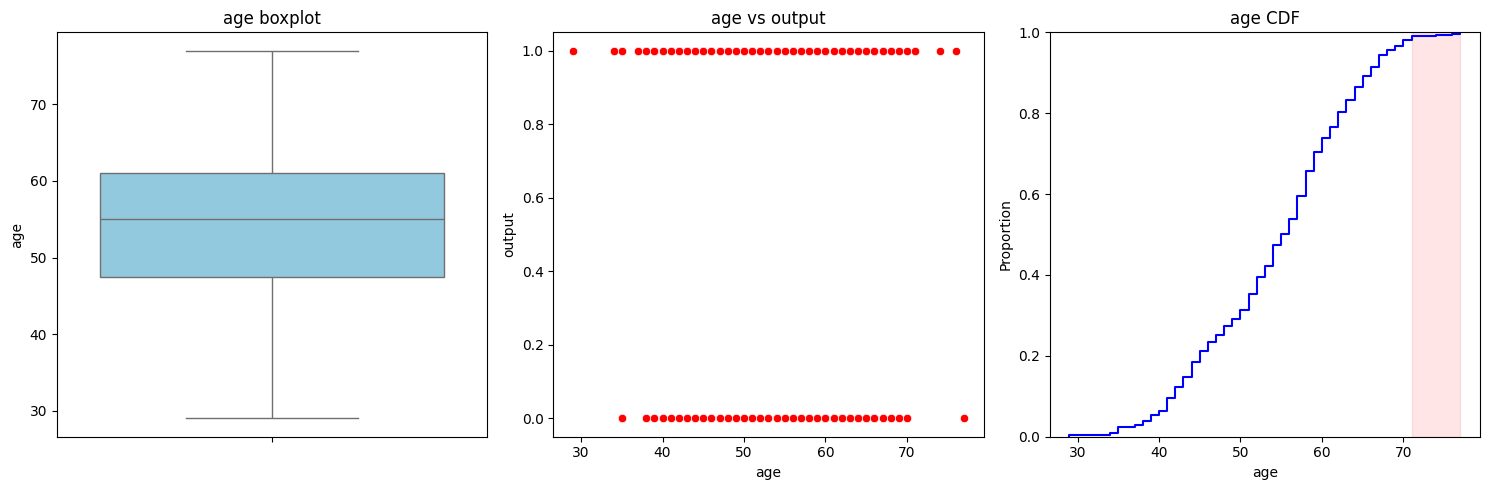

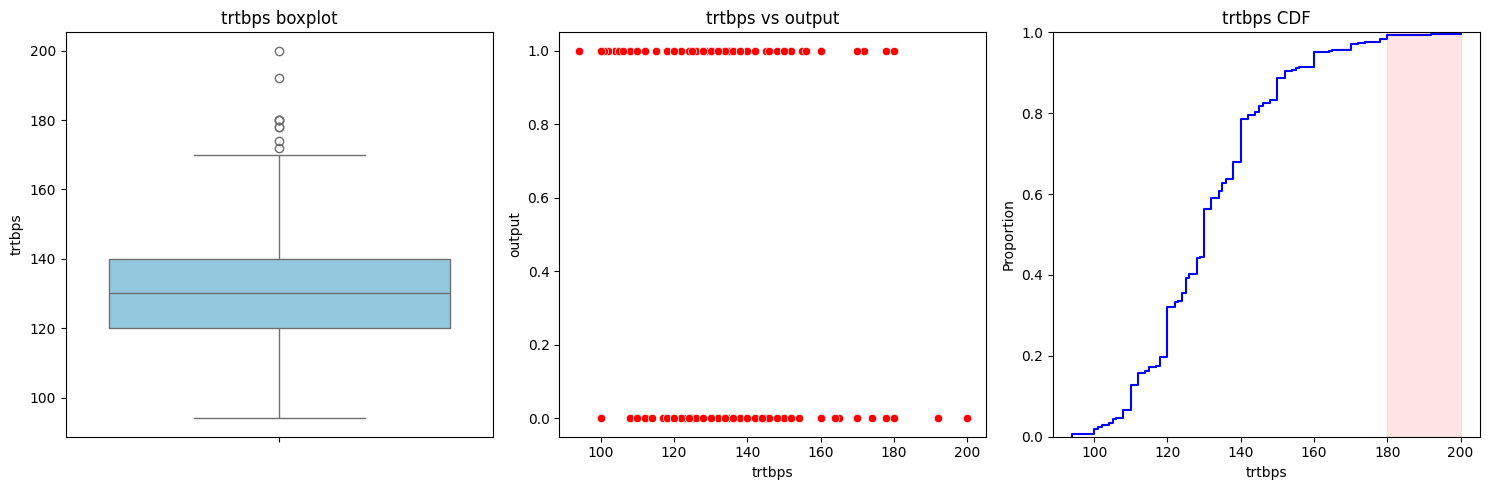

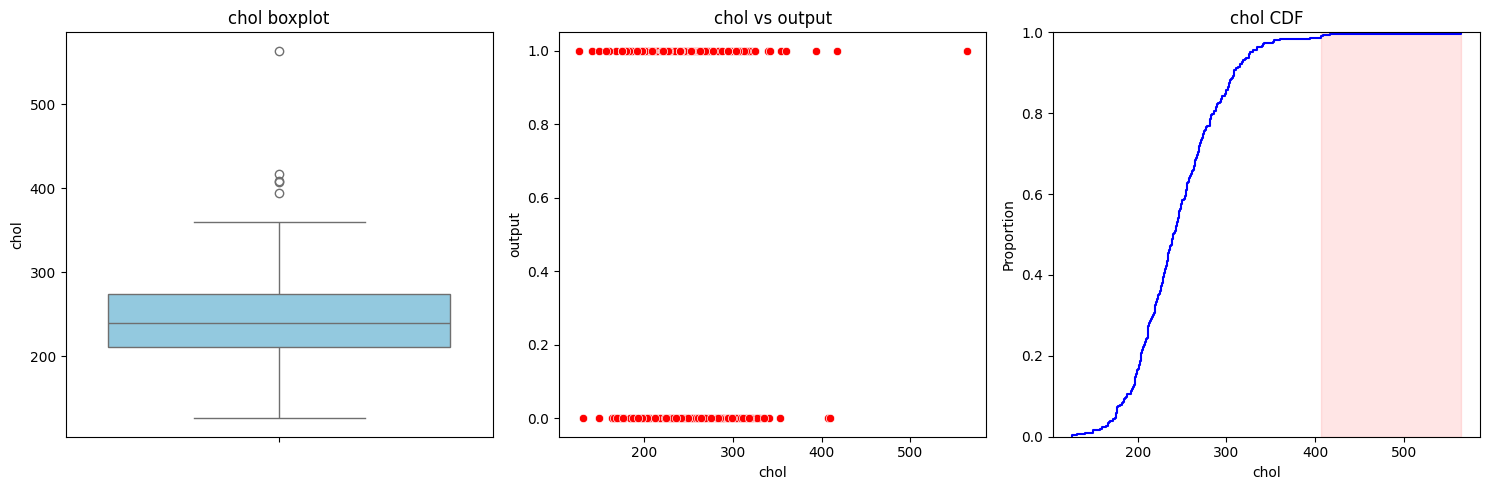

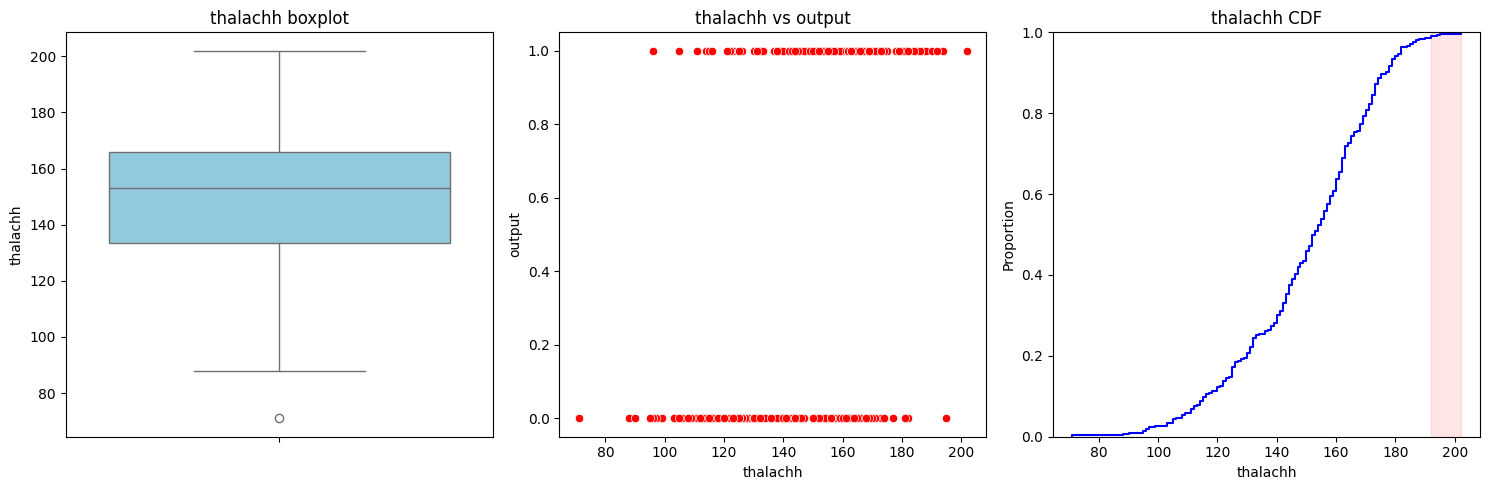

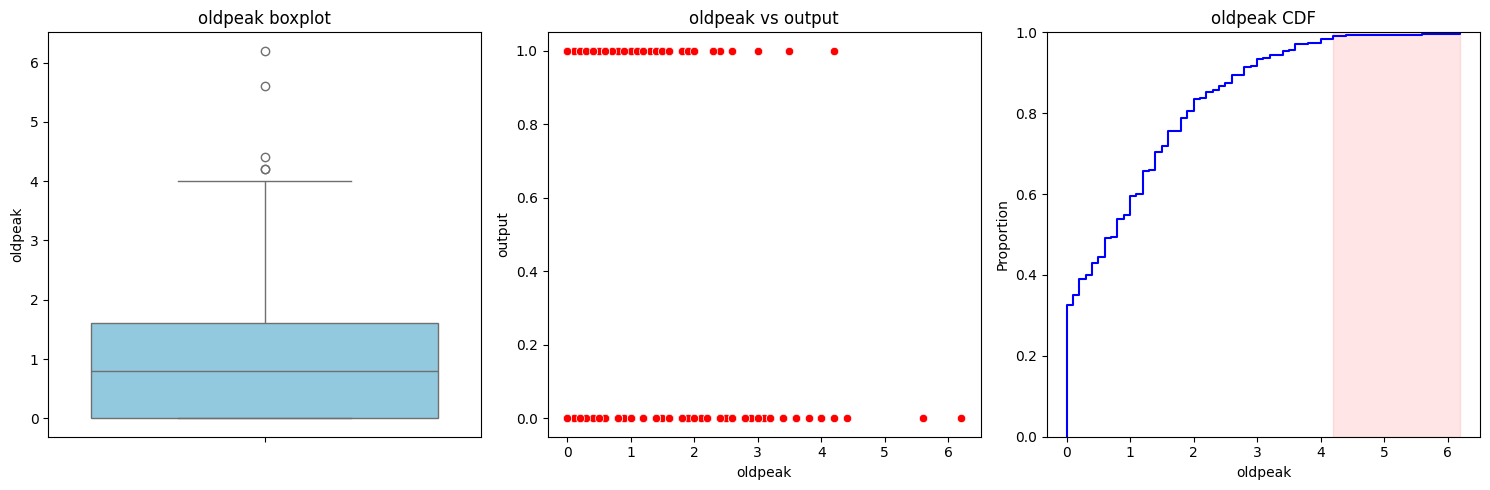

In [13]:
def plot_outliers(data : pd.DataFrame, feature : str, target_column : str) -> None:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    sns.boxplot(y=data[feature], ax=ax[0], color = 'skyblue')
    ax[0].set_title(f"{feature} boxplot")
    sns.scatterplot(x=data[feature], y=data[target_column], ax=ax[1], color = 'red')
    ax[1].set_title(f"{feature} vs {target_column}")
    #cdf
    sns.ecdfplot(data[feature], ax=ax[2], color = 'blue')
    ax[2].set_title(f"{feature} CDF")
    ax[2].axvspan(data[feature].quantile(0.99), data[feature].max(), color="red", alpha=0.1)
    plt.tight_layout()
    plt.show()

for feature in NUMERICAL_COLS:
    plot_outliers(HEART_DATA, feature, TARGET_COLUMN)

It does not seem like there are any significant outliers in the data, and the data is quite clean. So I will proceed with the data as is without removing any outliers.

# 2. Data visualization and analysis

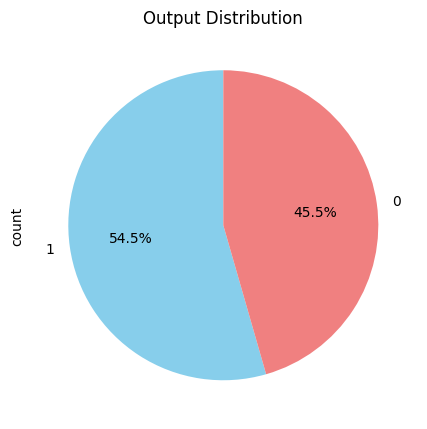

In [59]:
#Sector diagram of output
plt.figure(figsize=(5, 10))
HEART_DATA['output'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Output Distribution')
plt.show()

## 2.1 Categorical columns

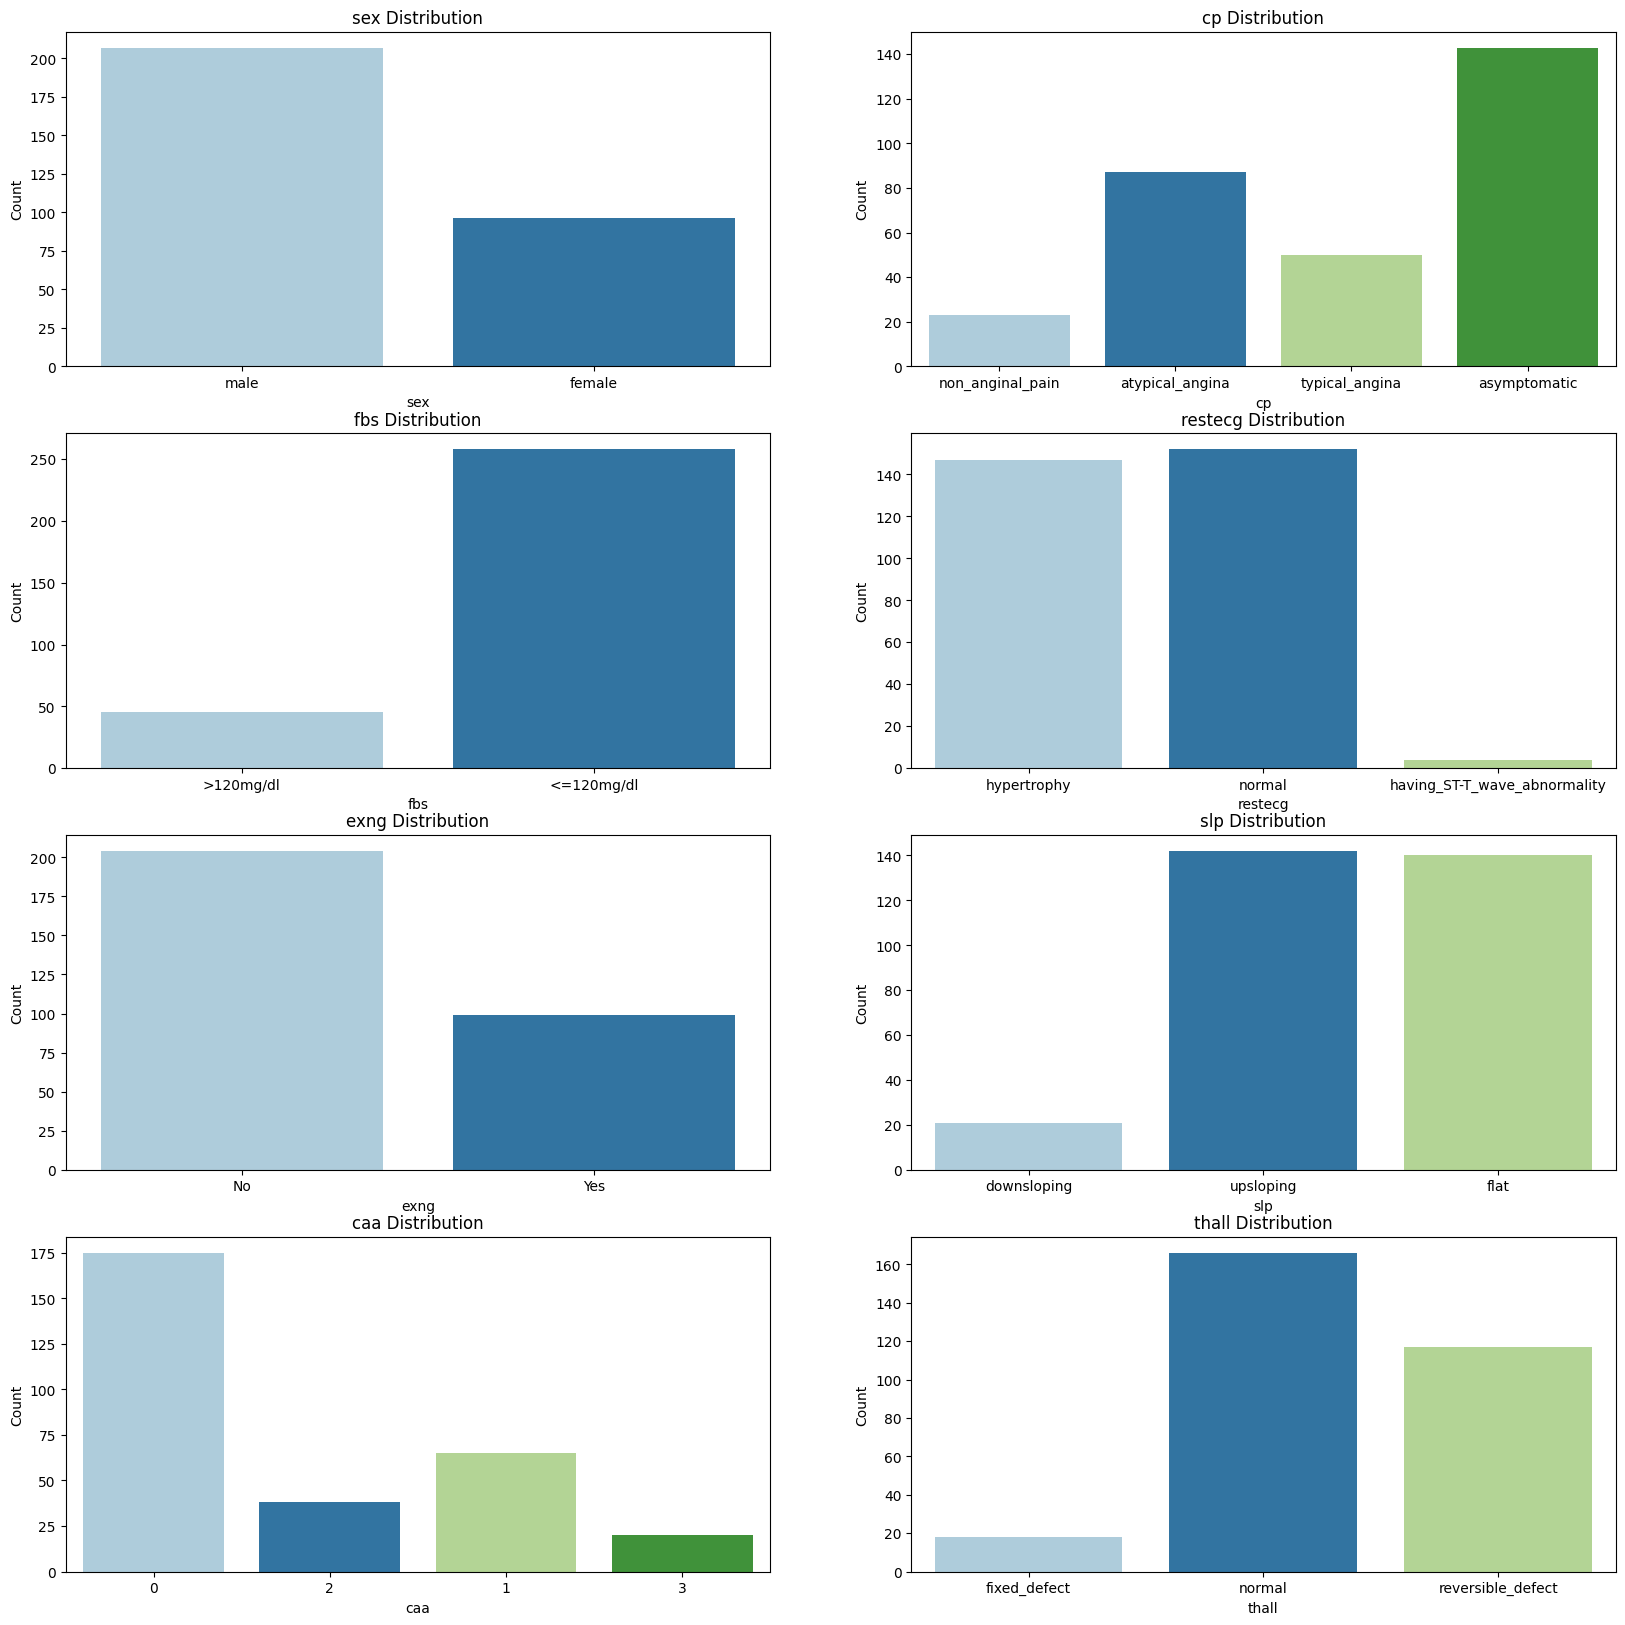

In [49]:
fix, axes = plt.subplots(4, 2, figsize=(20, 20))
for col in CATEGORICAL_COLS:
    sns.countplot(
        x=col,
        data=HEART_DATA_READABLE,
        ax=axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2],
        palette='Paired'
    )
    axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2].set_title(
        f"{col} Distribution"
    )
    axes[
        CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2
    ].set_ylabel("Count")
plt.show()

## 2.2 Numerical columns

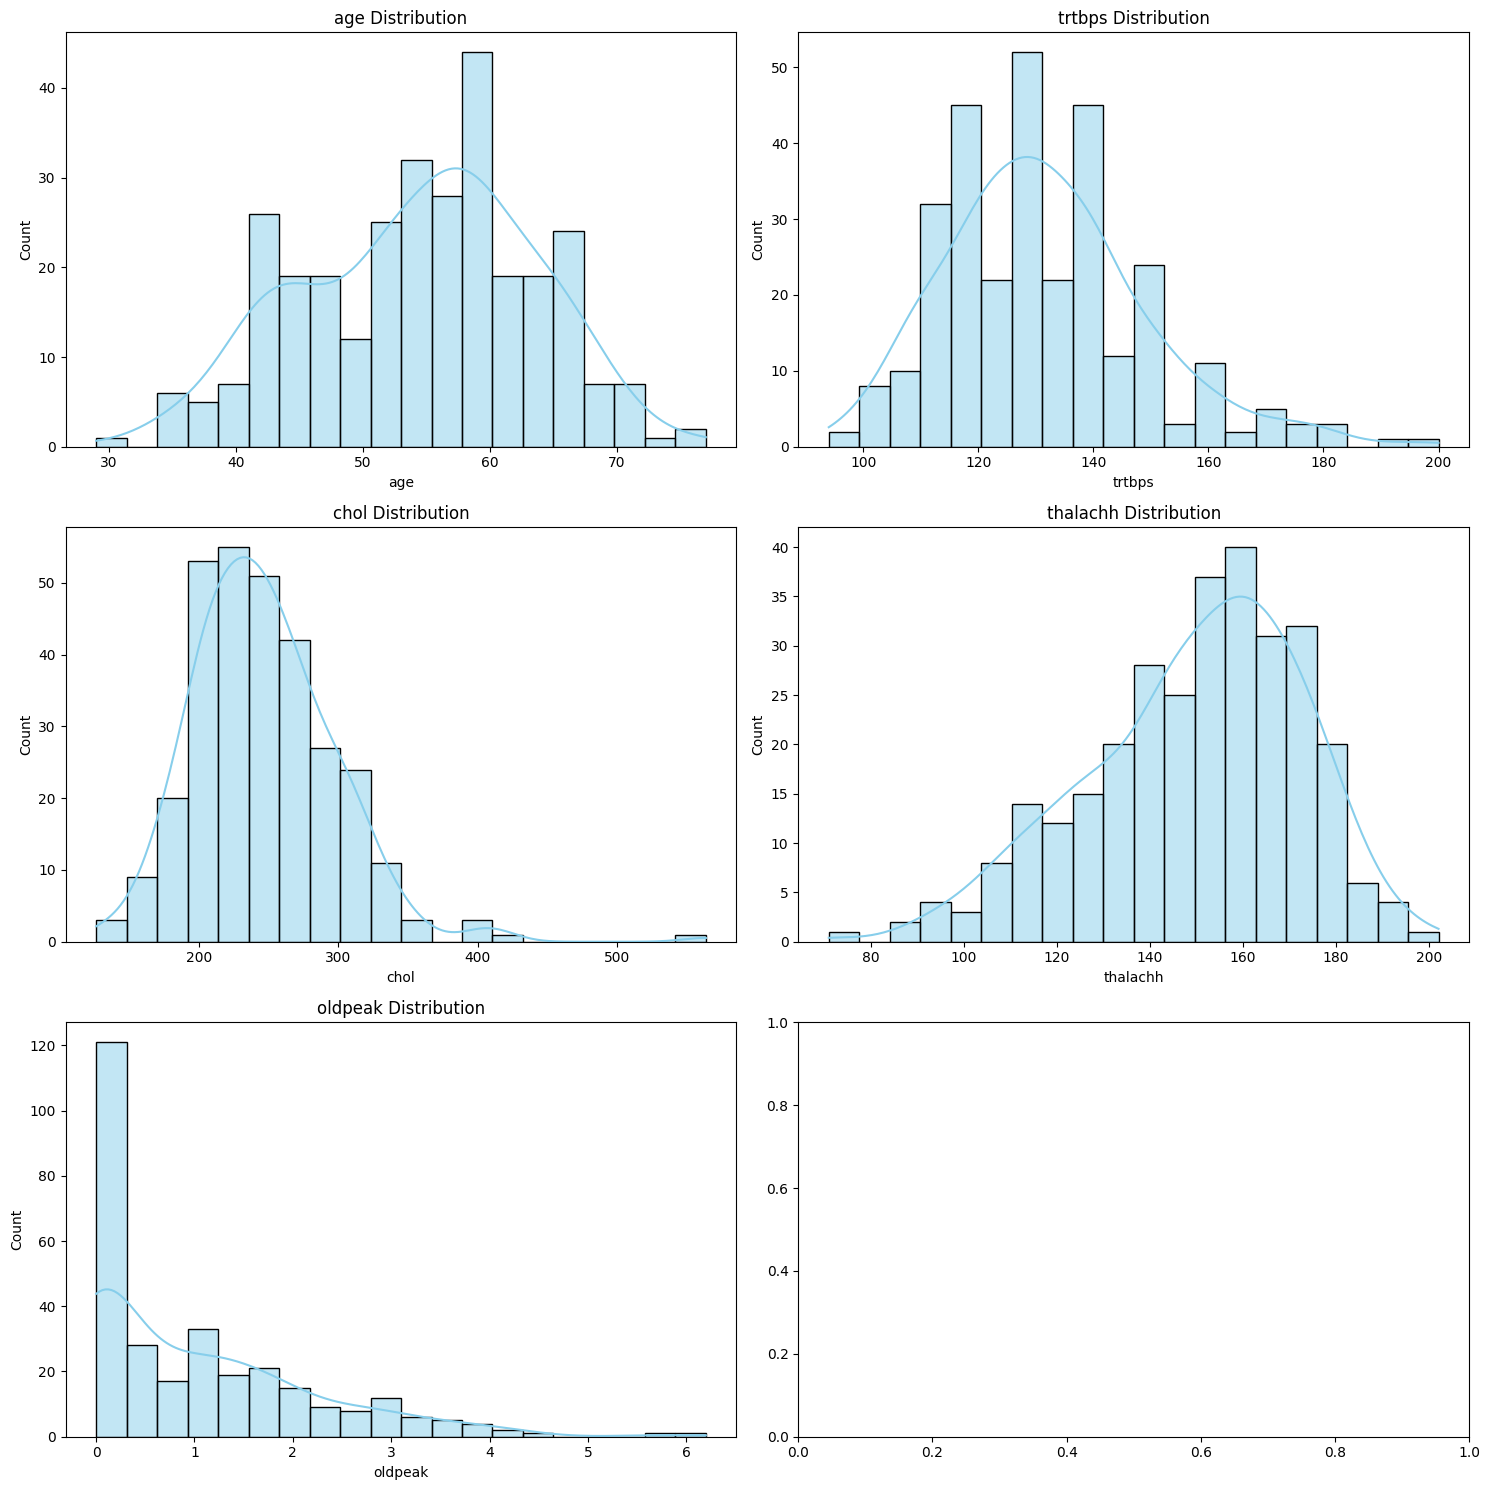

In [66]:
fig,axes = plt.subplots(3,2, figsize = (15,15))
r, c = 0,0
for column in NUMERICAL_COLS: 
    sns.histplot(HEART_DATA[column], kde=True, ax=axes[r,c], bins = 20, color='skyblue')
    axes[r,c].set_title(f'{column} Distribution')
    c+=1
    if c == 2:
        c = 0
        r += 1

plt.tight_layout()
plt.show()

## 2.3 Correlation analysis

### Correlation matrix numerical features

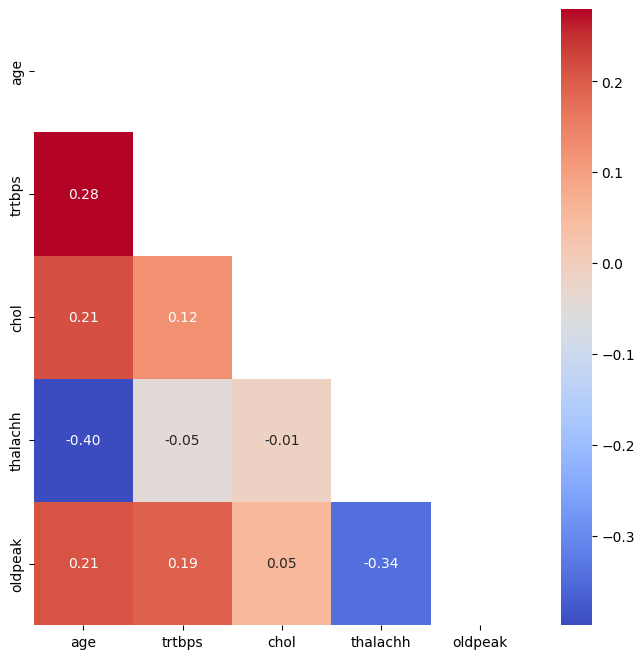

In [16]:
#Correlation matrix for numerical features
def plot_heat_num(df : pd.DataFrame):
    df_corr = df.corr()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    plt.figure(figsize=(8,8))
    sns.heatmap(df_corr, mask = mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

scaler = StandardScaler()
NUM_SCALED = scaler.fit_transform(HEART_DATA[NUMERICAL_COLS])
NUMERICAL_DF_SCALED = pd.DataFrame(NUM_SCALED, columns=NUMERICAL_COLS)
plot_heat_num(NUMERICAL_DF_SCALED)

### Correlation matrix all features (encoded categorical)

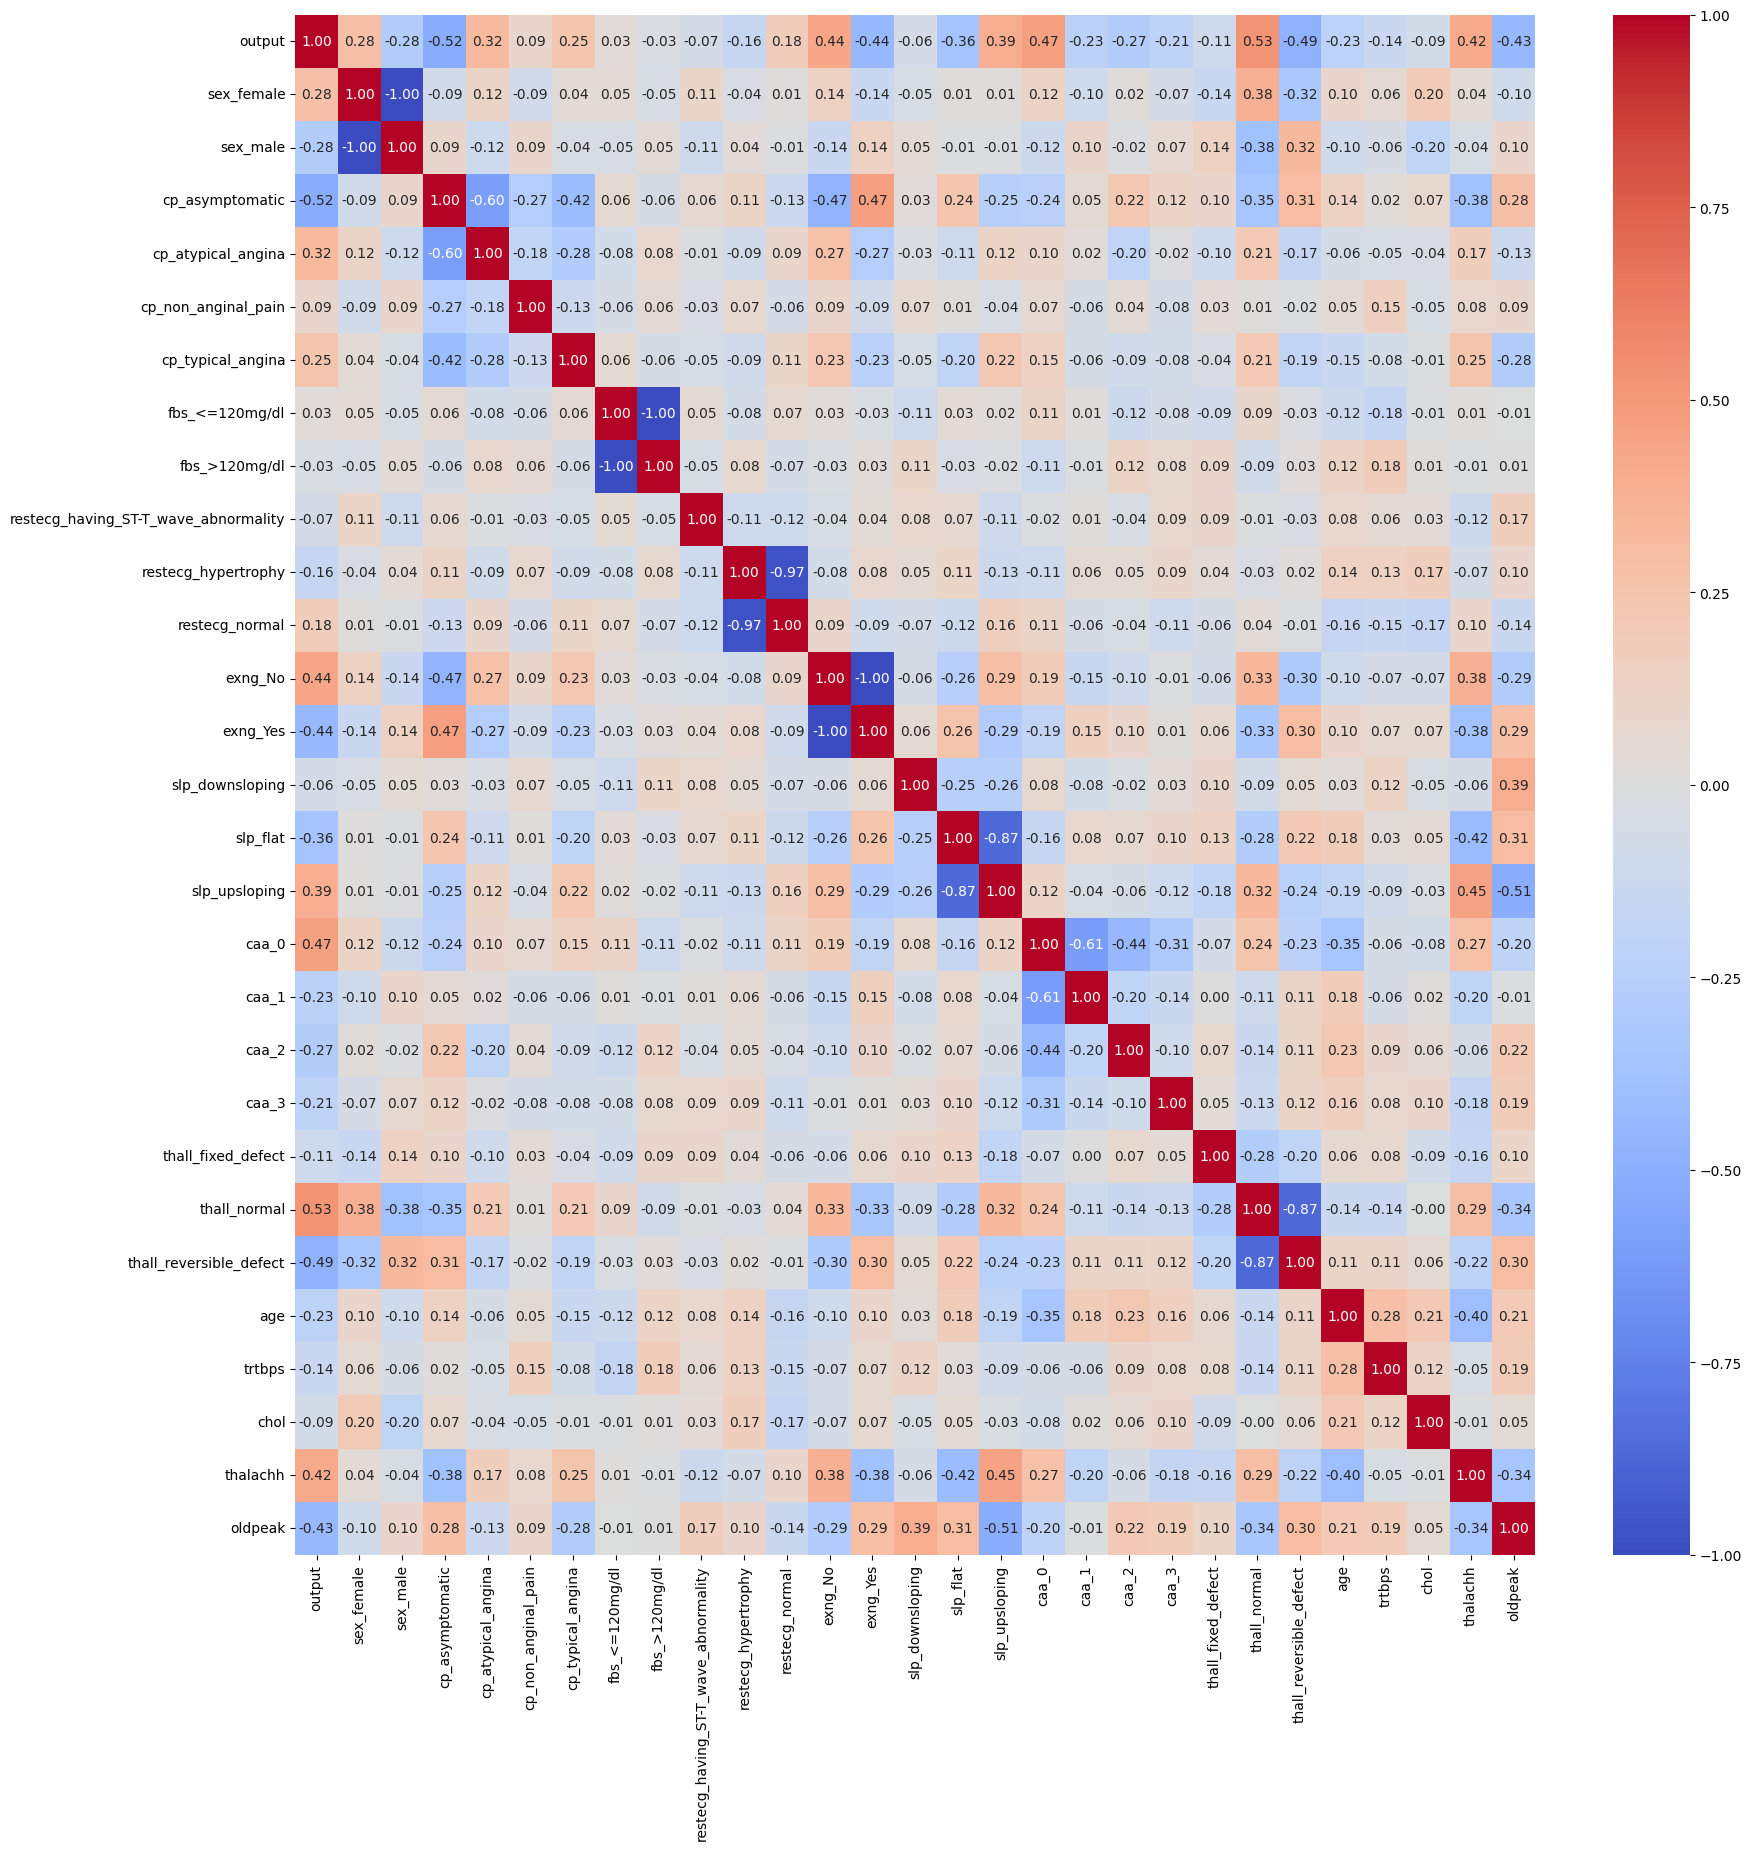

In [17]:
#Encode the categorical columns
DUMMY_DF = pd.get_dummies(HEART_DATA_READABLE, columns=CATEGORICAL_COLS, drop_first=False)
DUMMY_DF = DUMMY_DF.drop(NUMERICAL_COLS, axis=1)
MATRIX_DF = pd.concat([DUMMY_DF, NUMERICAL_DF_SCALED], axis=1)

def plot_heat_all(df : pd.DataFrame):
    df_corr = df.corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()
plot_heat_all(MATRIX_DF)

### Correlation with target

In [18]:
CORR_TARGET = MATRIX_DF.corr()[TARGET_COLUMN].sort_values(ascending=False)
CORR_TARGET.drop(TARGET_COLUMN, inplace=True)
CORR_TARGET_TABLE = CORR_TARGET.to_frame().reset_index()
CORR_TARGET_TABLE.columns = ['Feature', 'Correlation with Target']
CORR_TARGET_TABLE.style.background_gradient(cmap='coolwarm')

,Feature,Correlation with Target
0,thall_normal,0.527334
1,caa_0,0.465590
2,exng_No,0.436757
3,thalachh,0.421741
4,slp_upsloping,0.394066
5,cp_atypical_angina,0.316742
6,sex_female,0.280937
7,cp_typical_angina,0.245879
8,restecg_normal,0.175322
9,cp_non_anginal_pain,0.086957


## 2.4. Association rule mining 

Before performing the ARM, I want to add the age-values into equal sized bins and add a column for the bins. 

In [19]:
HEART_DATA_ARM = HEART_DATA.copy()
ages = HEART_DATA_ARM[['age']]

HEART_DATA_ARM['age_bins'] = pd.qcut(HEART_DATA_ARM['age'], q=3, labels=["1", "2", "3"])

#Want to see the age ranges for each bins 
age_bin_ranges = HEART_DATA_ARM.groupby('age_bins')['age'].agg(['min', 'max']).reset_index()
age_bin_ranges


,age_bins,min,max
0,1,29,51
1,2,52,59
2,3,60,77


Will then add a mapping from the age_bin to a more descriptive name of each categoru to the category map. 

In [20]:
#do it more generic by ussing age_cluster_ranges
CATEGORY_MAP['age_bins'] = {i: f"{age_bin_ranges['min'][i]}_to_{age_bin_ranges['max'][i]}" for i in range(3)}

### Find frequent itemsets

In [21]:
COLS_TO_ENCODE = CATEGORICAL_COLS + ['age_bins', 'output']
ENCODER, ENCODED_FEATURE_COLS, FEATURE_GROUPS = create_encoder(HEART_DATA_ARM, COLS_TO_ENCODE)
HEART_DATA_ONE_HOT = one_hot_encode_df(HEART_DATA_ARM, COLS_TO_ENCODE, ENCODER)
HEART_DATA_ONE_HOT_READABLE = make_readable_encoded_column_names(HEART_DATA_ONE_HOT, ENCODED_FEATURE_COLS.tolist(), CATEGORY_MAP)

In [22]:
HEART_DATA_ONE_HOT_READABLE

,age,trtbps,chol,thalachh,oldpeak,sex_female,sex_male,cp_asymptomatic,cp_typical_angina,cp_atypical_angina,...,caa_2,caa_3,thall_fixed_defect,thall_normal,thall_reversible_defect,age_bins_52_to_59,age_bins_60_to_77,age_bins_3,output_0,output_1
0,63,145,233,150,2.3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,37,130,250,187,3.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,41,130,204,172,1.4,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,56,120,236,178,0.8,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,57,120,354,163,0.6,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
299,45,110,264,132,1.2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
300,68,144,193,141,3.4,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
301,57,130,131,115,1.2,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
#Finding frequent itemsets for the categorical columns
CATEGORICAL_DATA_ONE_HOT = HEART_DATA_ONE_HOT_READABLE[HEART_DATA_ONE_HOT_READABLE.columns.difference(NUMERICAL_COLS + [TARGET_COLUMN])]
CATEGORICAL_DATA_ONE_HOT
FREQ_ITEMSETS = apriori(CATEGORICAL_DATA_ONE_HOT, min_support= 0.4, use_colnames=True)
ASSOCIATION_RULES = association_rules(FREQ_ITEMSETS, metric="confidence", min_threshold=0.8, num_itemsets=len(FREQ_ITEMSETS))
ASSOCIATION_RULES.to_csv('data/association_rules.csv')
ASSOCIATION_RULES[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(caa_0),(fbs_<=120mg/dl),0.524752,0.883333,1.037403
1,(output_1),(caa_0),0.442244,0.812121,1.367071
2,(cp_asymptomatic),(fbs_<=120mg/dl),0.412541,0.874126,1.026590
3,(exng_No),(fbs_<=120mg/dl),0.577558,0.857843,1.007467
4,(output_1),(exng_No),0.468647,0.860606,1.278253
5,(thall_normal),(exng_No),0.448845,0.809524,1.202381
6,(output_1),(fbs_<=120mg/dl),0.468647,0.860606,1.010712
7,(restecg_normal),(fbs_<=120mg/dl),0.438944,0.875000,1.027616
8,(sex_male),(fbs_<=120mg/dl),0.574257,0.840580,0.987192
9,(slp_upsloping),(fbs_<=120mg/dl),0.402640,0.859155,1.009008


In [24]:
#Filtering strong association rules with lift > 1
STRONG_ASSOCIATION_RULES = ASSOCIATION_RULES[ASSOCIATION_RULES['lift'] > 1.0]
STRONG_ASSOCIATION_RULES = STRONG_ASSOCIATION_RULES.sort_values(by = "lift", ascending=False)
STRONG_ASSOCIATION_RULES.reset_index(drop=True, inplace=True)
STRONG_ASSOCIATION_RULES


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(output_1),(caa_0),0.544554,0.594059,0.442244,0.812121,1.367071,1.0,0.118747,2.160652,0.589552,0.635071,0.537177,0.778283
1,(output_1),(exng_No),0.544554,0.673267,0.468647,0.860606,1.278253,1.0,0.102016,2.343952,0.477955,0.625551,0.573370,0.778342
2,(thall_normal),(exng_No),0.554455,0.673267,0.448845,0.809524,1.202381,1.0,0.075548,1.715347,0.377778,0.576271,0.417027,0.738095
3,(caa_0),(fbs_<=120mg/dl),0.594059,0.851485,0.524752,0.883333,1.037403,1.0,0.018920,1.272984,0.088817,0.569892,0.214444,0.749806
4,(restecg_normal),(fbs_<=120mg/dl),0.501650,0.851485,0.438944,0.875000,1.027616,1.0,0.011796,1.188119,0.053926,0.480144,0.158333,0.695252
5,(thall_normal),(fbs_<=120mg/dl),0.554455,0.851485,0.485149,0.875000,1.027616,1.0,0.013038,1.188119,0.060317,0.526882,0.158333,0.722384
6,(cp_asymptomatic),(fbs_<=120mg/dl),0.471947,0.851485,0.412541,0.874126,1.026590,1.0,0.010685,1.179868,0.049050,0.452899,0.152448,0.679311
7,(output_1),(fbs_<=120mg/dl),0.544554,0.851485,0.468647,0.860606,1.010712,1.0,0.004967,1.065433,0.023270,0.505338,0.061414,0.705497
8,(slp_upsloping),(fbs_<=120mg/dl),0.468647,0.851485,0.402640,0.859155,1.009008,1.0,0.003594,1.054455,0.016801,0.438849,0.051643,0.666012
9,(exng_No),(fbs_<=120mg/dl),0.673267,0.851485,0.577558,0.857843,1.007467,1.0,0.004281,1.044725,0.022684,0.609756,0.042810,0.768069


In [25]:
antecedents = STRONG_ASSOCIATION_RULES['antecedents'].apply(lambda x: ', '.join(list(x))).tolist()
consequents = STRONG_ASSOCIATION_RULES['consequents'].apply(lambda x: ', '.join(list(x))).tolist()
lifts = STRONG_ASSOCIATION_RULES['lift']

nodes = list(set(antecedents + consequents))
node_indicies = {node: i for i, node in enumerate(nodes)}

links = []
for ancentent, consequent, lift in zip(antecedents, consequents, lifts):
    links.append({
        'source': node_indicies[ancentent],
        'target': node_indicies[consequent],
        'value': lift
    })

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes
    ),
    link = dict(
      source = [link['source'] for link in links],
      target = [link['target'] for link in links],
      value = [link['value'] for link in links],
      color = 'blue',
    ))])
fig.update_layout(title_text="Sankey Diagram for Association Rules", font_size=10)
fig.show()

### Graph of the top 20 strong association rules

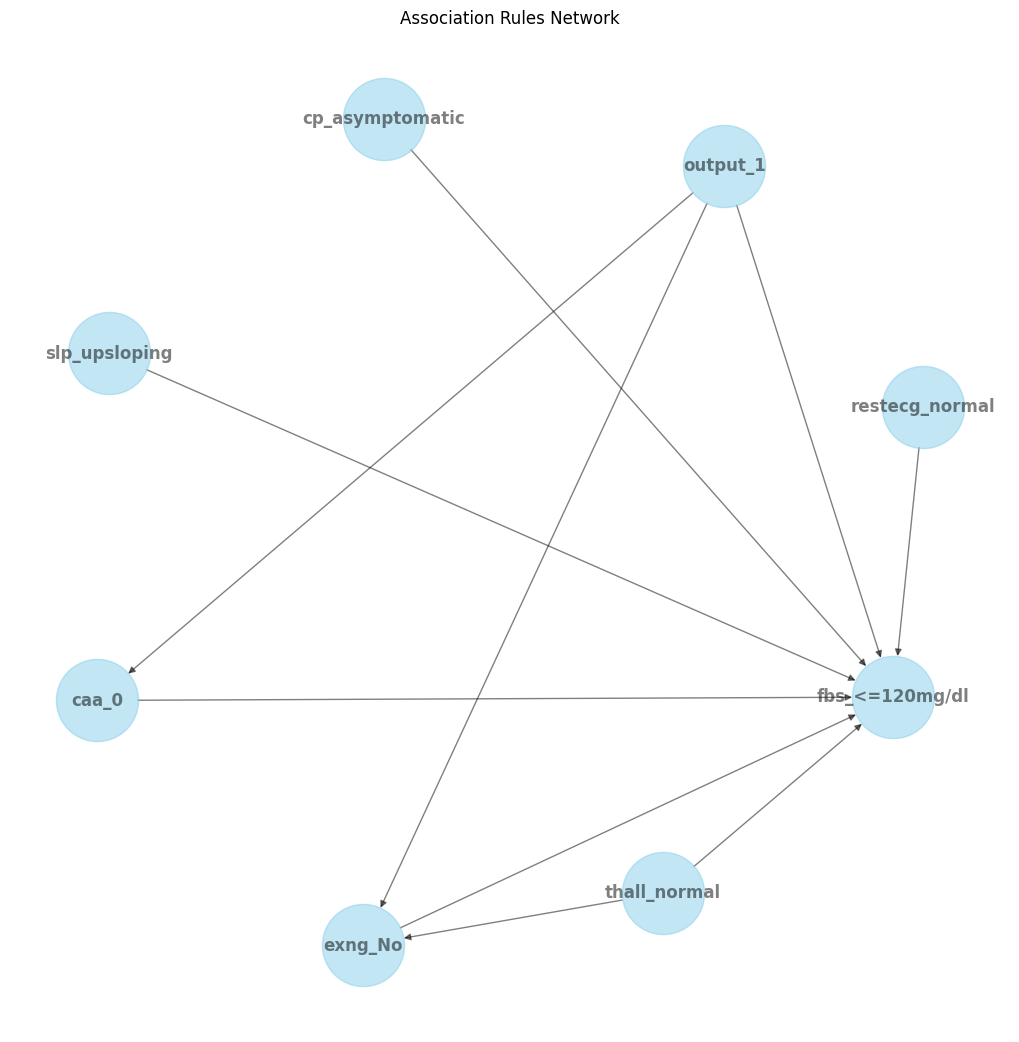

In [26]:
GRAPH_STRONG_ASSOCIATON_RULES = STRONG_ASSOCIATION_RULES.copy().head(20)
GRAPH_STRONG_ASSOCIATON_RULES["antecedents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "antecedents"
].apply(lambda x: ", ".join(list(x)))
GRAPH_STRONG_ASSOCIATON_RULES["consequents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "consequents"
].apply(lambda x: ", ".join(list(x)))

G = nx.from_pandas_edgelist(
    GRAPH_STRONG_ASSOCIATON_RULES,
    source="antecedents",
    target="consequents",
    edge_attr=True,
    create_using=nx.DiGraph(),
)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=4, seed=1)
nx.draw(G, with_labels=True, node_size=3500, node_color="skyblue", font_size=12, font_weight = 'bold', node_shape="o", alpha=0.5, pos=pos, arrows=True)
plt.title("Association Rules Network")
plt.show()

# 4. Feature engineering

## 4.1 Creating new features

In [27]:
def add_features(df : pd.DataFrame, numerical_cols : list, categorical_cols : list) -> tuple[pd.DataFrame, list[str], list[str]]:
    data = df.copy()
    categorical_cols_new = categorical_cols.copy()
    numerical_cols_new = numerical_cols.copy()
    #Adding grouped columns for the numerical features by using 
    for column in numerical_cols:
        try: 
            groups = pd.qcut(data[column], q = 3, labels = [f"{q}" for q in range(1,4)])
        except ValueError:
            continue
        #add groups for numerical columns to dataset and list of categorical values 
        named_groups = groups.rename(f"{column}_group")
        data = pd.concat([data, named_groups], axis = 1)
        categorical_cols_new.append(named_groups.name)
    
    #Interaction features 
    data['age_thalachh'] = data['age'] * data['thalachh']
    numerical_cols_new.append('age_thalachh')
    data['age_oldpeak'] = data['age'] * data['oldpeak']
    numerical_cols_new.append('age_oldpeak')
    data['age_chol'] = data['age'] * data['chol']
    numerical_cols_new.append('age_chol')
    data['chol_age_ratio'] = data['chol'] / data['age']
    numerical_cols_new.append('chol_age_ratio')
    
    #Add target column to the end of the dataframe
    data = data.drop(TARGET_COLUMN, axis=1).join(df[TARGET_COLUMN])
    
    
    return data, numerical_cols_new, categorical_cols_new

HEART_DATA_NEW, NUMERICAL_COLS_NEW, CATEGORICAL_COLS_NEW = add_features(HEART_DATA, NUMERICAL_COLS, CATEGORICAL_COLS)
HEART_DATA_NEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             303 non-null    int64   
 1   sex             303 non-null    int64   
 2   cp              303 non-null    int64   
 3   trtbps          303 non-null    int64   
 4   chol            303 non-null    int64   
 5   fbs             303 non-null    int64   
 6   restecg         303 non-null    int64   
 7   thalachh        303 non-null    int64   
 8   exng            303 non-null    int64   
 9   oldpeak         303 non-null    float64 
 10  slp             303 non-null    int64   
 11  caa             303 non-null    int64   
 12  thall           303 non-null    int64   
 13  age_group       303 non-null    category
 14  trtbps_group    303 non-null    category
 15  chol_group      303 non-null    category
 16  thalachh_group  303 non-null    category
 17  oldpeak_group   

# 5. Data preprocessing

## 5.1 Train-test-split

In [28]:
# Target column and feature set
y = HEART_DATA_NEW[TARGET_COLUMN]
X = HEART_DATA_NEW.drop(TARGET_COLUMN, axis = 1)

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5.2 Normalize and encode 

In [ ]:
#Normalize the numerical data using MinMaxScaler
NUM_TRANSFORMER = Pipeline(steps=[('scaler', MinMaxScaler())])

#For linear models, it is necessary to encode the categorical data to avoid introducing unintented relationships and biased.  
CAT_TRANSFORMER = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Define a pre processer
PRE_PROCESSOR = ColumnTransformer(transformers=[
    ('num', NUM_TRANSFORMER, NUMERICAL_COLS_NEW),
    ('cat', CAT_TRANSFORMER, CATEGORICAL_COLS_NEW)
])

## 5.3 PCA - reduce data dimensions 

In [30]:
# Find best parameters for PCA
PCA_PIPELINE = Pipeline(
    steps=[
        ("preprocessor", PRE_PROCESSOR),
        ("pca", PCA()),
        ("model", LinearRegression()),
    ]
)
PCA_PARAM_GRID = {
    "pca__n_components": range(1, PRE_PROCESSOR.fit_transform(X_train).shape[1] + 1)
}

PCA_GRID_SEARCH = GridSearchCV(
    estimator=PCA_PIPELINE,
    param_grid=PCA_PARAM_GRID,
    scoring="neg_mean_squared_error",
    cv=5,
)

PCA_GRID_SEARCH.fit(X_train, np.log1p(y_train))
# Obtain the best number of parameters for PCA
BEST_PARAM_PCA_SEARCH = PCA_GRID_SEARCH.best_params_
BEST_SCORE_PCA_SEARCH = PCA_GRID_SEARCH.best_score_

print(f"Best parameters for PCA: {BEST_PARAM_PCA_SEARCH}")
print(f"Best score for PCA: {BEST_SCORE_PCA_SEARCH}")

BEST_PARAM_PCA = {}
for key, value in BEST_PARAM_PCA_SEARCH.items():
    BEST_PARAM_PCA[key.split("__")[1]] = value

BEST_PARAM_PCA
PCA_BEST = PCA(n_components=BEST_PARAM_PCA["n_components"])

PRE_PROCESSOR_PCA_BEST = Pipeline(
    steps=[("preprocessor", PRE_PROCESSOR), ("pca", PCA_BEST)]
)
PCA_2 = PCA(n_components=2)
PRE_PROCESSOR_PCA_2 = Pipeline(steps=[("preprocessor", PRE_PROCESSOR), ("pca", PCA_2)])

Best parameters for PCA: {'pca__n_components': 5}
Best score for PCA: -0.06273483842978203


# 6. Unsupervised learning models - Clustering analysis

Before clustering I will scatter plot the data to see if there is possible to observe any clusters in the data (train and test together)

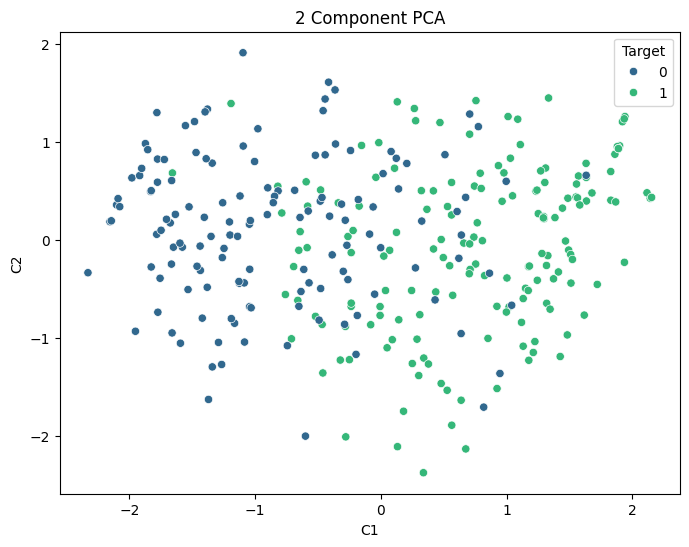

In [31]:
pca_2 = PCA(n_components=2)
X_pca = PRE_PROCESSOR_PCA_2.fit_transform(X)

DF_PCA_2 = pd.DataFrame(X_pca, columns=["C1", "C2"])
DF_PCA_2["Target"] = y
plt.figure(figsize=(8, 6))
sns.scatterplot(DF_PCA_2, x='C1', y='C2', hue='Target', palette='viridis')
plt.title('2 Component PCA')
plt.show()


The color represents the Target variable, and the points do not form clearly separated clusters. Instead, there is a large overlapping central region with a few outliers scattered farther away. This suggests the data may lack strong inherent clusters. Clustering methods like K-Means or Agglomerative Clustering may struggle to form meaningful clusters due to the lack of clear boundaries. However, density-based methods like DBSCAN might still be useful for identifying outliers or small, dense subgroups.

### Some helping functions

In [32]:
#Some helping functions for the clustering analysis 
#Finding the optimal k for K-means
def find_optimal_k(X_scaled : np.array) -> tuple[int, float]:
    k_values = range(2,11)
    silhouette_scores = {}
    inertia_values = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores[k] = score
        inertia_values.append(kmeans.inertia_)
        
    optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    optimal_score = silhouette_scores[optimal_k]
    print(f"Optimal number of clusters: {optimal_k}")
    print (f"Optimal silhouette score: {optimal_score}")
    return optimal_k, optimal_score

def find_k_plot(silhouette_scores : dict[int, float], inertia_values : list[float]) -> None:
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.plot(silhouette_scores.keys(), silhouette_scores.values(), marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of clusters')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(2,11), inertia_values, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of clusters')
    plt.grid(True)

def find_optimal_eps(X_scaled : np.array, eps_range, min_samples_range) -> tuple[float, float]:
    best_score = -1
    best_params = None
    results = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X_scaled)
            
            #Skip cases with 1 cluster 
            if len(set(cluster_labels)) > 1:
                score = silhouette_score(X_scaled, cluster_labels)
                results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
    sorted_results = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
    return best_params, best_score, sorted_results


We might want to reduce the dimensionality to 2 for better visualization of the clustering. 
To do this I will perform clustering on two different arrays, one array is obtain from using PCA with n_components=2, and one array is obtained from using PCA with n_components = 12 (which is the best parameter we found) and then perform t-SNE to reduce the dimensionality to 2. We will then look for differences in the silohuette score. 

In [33]:
#PCA-only (2D)
pca_n_2 = PCA(n_components=2)
X_train_pca_2 = pca_n_2.fit_transform(X_train)
X_test_pca_2 = pca_n_2.transform(X_test)

#PCA + t-SNE (4D to 2D)
X_train_pca = PRE_PROCESSOR_PCA_BEST.fit_transform(X_train)
tsne_2 = TSNE(n_components=2, random_state=42)
X_train_pca_tsne = tsne_2.fit_transform(X_train_pca)

optimal_k_pca_2, optimal_score_pca_2 = find_optimal_k(X_train_pca_2)
optimal_k_pca_tsne, optimal_score_pca_tsne = find_optimal_k(X_train_pca_tsne)

Optimal number of clusters: 2
Optimal silhouette score: 0.47105590763433053
Optimal number of clusters: 2
Optimal silhouette score: 0.46702978014945984


We can see that the optimal k is 2 for both but that the silhouette score is slighly better when we only use PCA. I will therefore continue using the array where pca were performed. 


In [34]:
OPTIMAL_K, OPTIMAL_SCORE = find_optimal_k(X_train_pca_2)
EPS_RANGE = np.linspace(0.1, 1.0, 10)
min_samples_range = range(2, 11)
DBSCAN_BEST_PARAMS, DBSCAN_BEST_SCORE, DBSCAN_SORTED_RESULTS = find_optimal_eps(X_train_pca_2, EPS_RANGE, min_samples_range)
DBSCAN_BEST_PARAMS

Optimal number of clusters: 2
Optimal silhouette score: 0.47105590763433053


{'eps': 0.1, 'min_samples': 2}

In [35]:
# Finding the best clustering method
CLUSTERING_METHODS = [
    {"model": DBSCAN,
     "name": "DBSCAN",
     "params": DBSCAN_BEST_PARAMS},
    {"model": AgglomerativeClustering,
     "name": "Agglomerative Clustering",
     "params": {
         'n_clusters': 3
     }},
    {"model": KMeans,
     "name": "KMeans",
     "params": {
         'n_clusters': optimal_k_pca_2
     }},
    ]
for method in CLUSTERING_METHODS:
    model = method["model"](**method["params"])
    cluster_labels = model.fit_predict(X_train_pca_2)
    if len(set(cluster_labels)) > 1:  # Ensure there is more than one cluster
        silhouette = silhouette_score(X_train_pca_2, cluster_labels)
        print(f"{method['name']} silhouette score: {silhouette}")
    else:
        print(f"{method['name']} did not produce more than one cluster.")

DBSCAN silhouette score: 0.22242091808849698
Agglomerative Clustering silhouette score: 0.44484847597638677
KMeans silhouette score: 0.47423340562910227


KMeans are giving the best silhouette score, so we will continue to use this method for the clustering. 

In [36]:
kmeans_2D = KMeans(n_clusters=OPTIMAL_K, random_state=42)
cluster_labels_2D = kmeans_2D.fit_predict(X_train_pca_2)

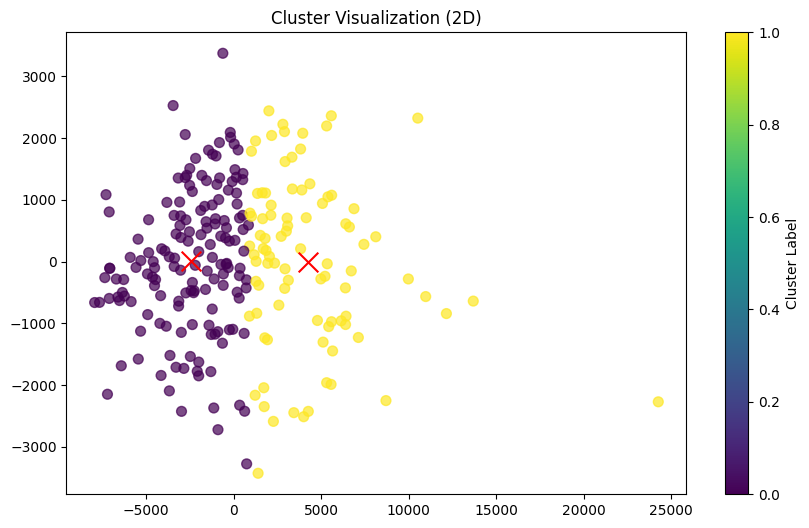

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=cluster_labels_2D, cmap='viridis', s=50, alpha=0.7, marker = 'o')
plt.scatter(kmeans_2D.cluster_centers_[:, 0], kmeans_2D.cluster_centers_[:, 1], s=200, c='red', marker='x')
plt.title('Cluster Visualization (2D)')
plt.colorbar(label='Cluster Label')

The K-Means clustering with two clusters divides the data into two regions centered around the red centroids, creating a simple boundary near the middle of the points. The clusters are somewhat symmetrical but show significant overlap, suggesting that the data lacks a clear, natural separation into two distinct groups. This forced division likely reflects a gradient in the data rather than meaningful clusters, limiting its informational value. The centroids are positioned near the densest regions, but the overall clustering does not capture strongly separated structures, indicating that K-Means may not be the optimal method for this dataset.

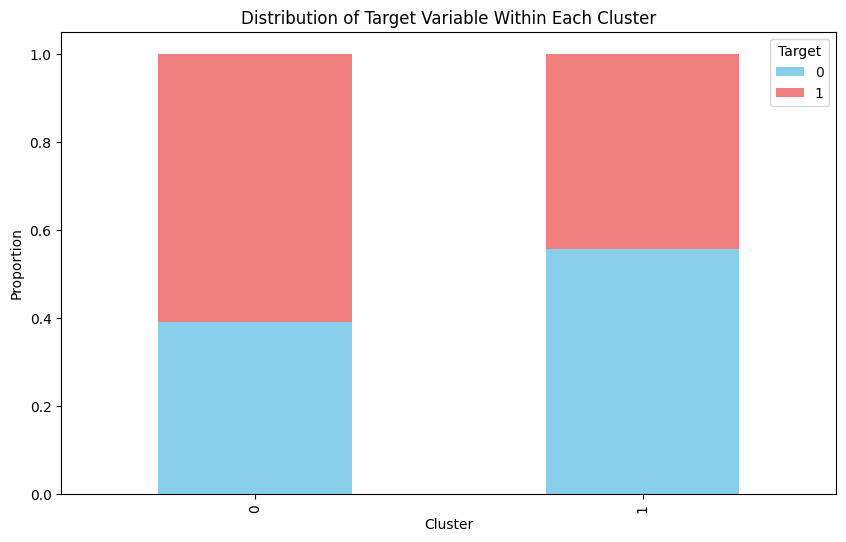

In [71]:
cluster_analysis_df = pd.DataFrame({
    "Cluster": cluster_labels_2D,
    "Target": y_train
})
cluster_distribution = cluster_analysis_df.groupby("Cluster")["Target"].value_counts(normalize=True).unstack()
cluster_distribution.plot(kind="bar", stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])
plt.title("Distribution of Target Variable Within Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="Target", loc="upper right")
plt.show()

Make a dataframe with the cluster labels from Kmeans, and the PCA components. 
We can try to use this to predict the target variable and compare to the predictions done with other datasets

In [39]:
X_train_kmeans = X_train.copy()
X_train_kmeans['kmeans_label'] = kmeans_2D.fit_predict(X_train_pca_2)
X_test_kmeans = X_test.copy()
X_test_kmeans['kmeans_label'] = kmeans_2D.predict(X_test_pca_2)

Density-based clustering (e.g., DBSCAN) might still be useful for identifying outliers or smaller subgroups. But DBSCAN is not typically suited for clustering as a preprocessing step for classification.  Instead, it excels in other specific scenarios like outlier detection and identifying densely packed subgroups So the DBScan will only be performed for visualization and insights and will not be used in any further classification

Number of clusters found (excluding noise): 26
Unique labels (including noise if present): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]


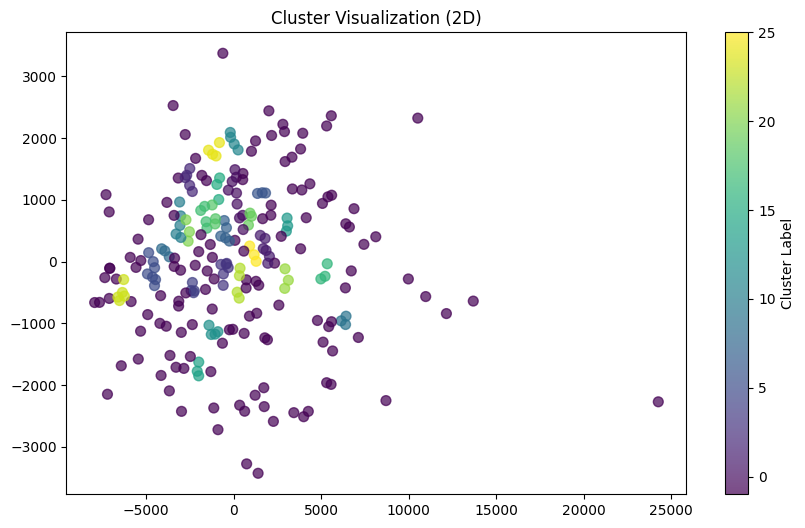

In [103]:
dbscan = DBSCAN(eps=300, min_samples=3)
cluster_labels_dbscan = dbscan.fit_predict(X_train_pca_2)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=cluster_labels_dbscan, cmap='viridis', s=50, alpha=0.7, marker = 'o')
plt.title('Cluster Visualization (2D)')
plt.colorbar(label='Cluster Label')
unique_clusters = np.unique(cluster_labels_dbscan)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
print(f"Number of clusters found (excluding noise): {n_clusters}")
print(f"Unique labels (including noise if present): {unique_clusters}")


# 7. Supervised learning models - Classification analysis

In [41]:
#Fit and transform training data
X_train = PRE_PROCESSOR.fit_transform(X_train)
X_test  = PRE_PROCESSOR.transform(X_test)

In [ ]:
#Helping functions 
from skopt.space import Real, Integer, Categorical


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    return acc_train, acc_test, y_test_pred

def plot_confusion_matrix(cm, target_names):
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


def train_and_validate_model(data : pd.DataFrame, data_description : str, target_column : str, pre_processor_steps : Optional[Pipeline], classifier_and_params : dict, cluster : bool = False) -> tuple:
    y = data[target_column]
    X = data.drop(target_column, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    """pipeline = Pipeline(steps=[])
    if pre_processor is not None:
        for step in pre_processor.steps:
            pipeline.steps.append(step)"""
    # Handle clustering and adding the cluster_label column
    if cluster:
        kmeans = KMeans(n_clusters=find_optimal_k(X_train)[0], random_state=42)
        X_train['cluster_label'] = kmeans.fit_predict(X_train)
        X_test['cluster_label'] = kmeans.predict(X_test)

        # Dynamically update the CATEGORICAL_COLS to include cluster_label if not present
        if 'cluster_label' not in CATEGORICAL_COLS_NEW:
            CATEGORICAL_COLS_NEW.append('cluster_label')
        # Check the structure of pre_processor_steps
        if pre_processor_steps:
            for step in pre_processor_steps:
                # Step is a tuple (step_name, step_pipeline)
                step_name, step_pipeline = step

                # Identify the 'preprocessor' step
                if 'preprocessor' in step_name:
                    # Modify the preprocessor pipeline to include the updated CATEGORICAL_COLS
                    # Ensure you are modifying the ColumnTransformer inside the preprocessor step
                    for transformer_name, transformer_pipeline, columns in step_pipeline.transformers:
                        if transformer_name == 'cat':
                            # Modify the 'cat' transformer to include the updated CATEGORICAL_COLS
                            step_pipeline.transformers = [
                                ('num', NUM_TRANSFORMER, NUMERICAL_COLS_NEW),
                                ('cat', CAT_TRANSFORMER, CATEGORICAL_COLS_NEW)  # Now includes 'cluster_label'
                            ]
                            break
                    break  # Once we've updated the preprocessor, no need to continue checking
   
    classifier = classifier_and_params['classifier']
    param_grid = classifier_and_params['param_grid']
    
    steps = pre_processor_steps.copy()
    steps.append(('classifier', classifier))
    pipeline = Pipeline(steps=steps)
    
    #BayesSearchCV for faster hyperparameter tuning
    classifier_name = classifier.__class__.__name__
    if classifier_name in ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']:
        search_spaces = {}
        for param, values in param_grid.items():
            if all(isinstance(i, int) for i in values):
                if len(set(values)) == 1:
                    search_spaces[param] = Categorical(values)
                else:
                    search_spaces[param] = Integer(min(values), max(values))
            elif all(isinstance(i, float) for i in values):
                if len(set(values)) == 1:
                    search_spaces[param] = Categorical(values)
                else:
                    search_spaces[param] = Real(min(values), max(values))
            elif all(isinstance(i, bool) for i in values):
                search_spaces[param] = Categorical(values)
            else:
                search_spaces[param] = Categorical(values)

        search = BayesSearchCV(
            estimator=pipeline,
            search_spaces=search_spaces,
            n_iter=50,
            cv=5,
            n_jobs=-1,
            scoring='accuracy',
            random_state=42
        )
    else: 
        #Using gridsearch for others
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1
        )
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = -search.best_score_
    
    print(f"Best parameters: {best_params} for model {classifier}")
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    
    acc_train = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)

    
    acc_test = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precistion = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    

    
    print(f"Accuracy score on training data: {acc_train}")
    print(f"Accuracy score on test data: {acc_test}")
    
    current_performance = {
        'Classifier' : classifier.__class__.__name__,
        'Data' : data_description,
        'Selected parameters' : best_params,
        'CV score' : best_score,
        'Train_accuracy' : acc_train,
        'Test_accuracy' : acc_test,
        'Train_precision' : train_precision,
        'Test_precision' : test_precistion,
        'Train_recall' : train_recall,
        'Test_recall' : test_recall,
        'Train_f1' : train_f1,
        'Test_f1' : test_f1
        
        
    }
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    return best_model, current_performance, cm
    

### 6.1 Preprocessors

In [43]:
#Defining different pre processors i will use to compare the results. 

PRE_PROCESSORS = [
    ([('preprocessor', PRE_PROCESSOR)], "Without PCA"),
    ([('preprocessor', PRE_PROCESSOR), ('pca', PCA(**BEST_PARAM_PCA))], "PCA Best"),
]

### 6.2 Classifiers and parameter grids

In [44]:
# Set up classifiers and parameter grid
CLASSIFIERS_AND_PARAM_GRIDS = [
    {
        "classifier": LogisticRegression(random_state=42),
        "param_grid": {
            "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
            "classifier__penalty": ["l1", "l2"],
            "classifier__solver": ["liblinear"],
        },
    },
    {
        "classifier": SVC(random_state=42),
        "param_grid": {
            "classifier__C": [0.01, 0.1, 1, 10, 100],
            "classifier__kernel": ["linear", "rbf"],
            "classifier__degree": [2, 3, 4, 5],
        },
    },
    {
        "classifier": RandomForestClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__max_depth": [None, 5, 10, 15, 20],
            "classifier__max_features": ["sqrt", "log2"],
        },
    },
    {
        "classifier": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "classifier__max_depth": [5, 10, 15, None],
            "classifier__max_features": ["sqrt", "log2"],
        },
    },
    {
        "classifier": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__max_depth": [5, 10, 15],
            "classifier__max_features": ["sqrt", "log2"],
            "classifier__learning_rate": [0.01, 0.1, 0.3],
            "classifier__subsample": [0.6, 0.8, 1.0],
        },
    },
    {
        "classifier": XGBClassifier(random_state =42),
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__max_depth": [3, 5, 7],
            "classifier__learning_rate": [0.01, 0.1, 0.3],
            "classifier__subsample": [0.6, 0.8, 1.0],
            "classifier__colsample_bytree": [0.6, 0.8, 1.0],
        },
    },
    {
        "classifier": LGBMClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__max_depth": [-1, 10, 20],
            "classifier__learning_rate": [0.01, 0.1, 0.3],
            "classifier__subsample": [0.6, 0.8, 1.0],
            "classifier__num_leaves": [31, 50, 100],
        },
    },
    {
        "classifier": CatBoostClassifier(random_state=42),
        "param_grid": {
            "classifier__iterations": [100, 200, 300],
            "classifier__depth": [3, 5, 7],
            "classifier__learning_rate": [0.01, 0.1, 0.3],
        },
    },
    {
        "classifier": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__learning_rate": [0.01, 0.1, 0.3],
        },
    },
    {
        "classifier": KNeighborsClassifier(),
        "param_grid": {
            "classifier__n_neighbors": [3, 5, 7],
            "classifier__weights": ["uniform", "distance"],
            "classifier__p": [1, 2],
        },
    },
    {
        "classifier": MLPClassifier(random_state=42),
        "param_grid": {
            "classifier__hidden_layer_sizes": [(50, 50), (100, 100), (200, 200)],
            "classifier__activation": ["relu", "tanh", "logistic"],
            "classifier__alpha": [0.0001, 0.001, 0.01],
        },
    },
    {
        "classifier": GaussianNB(),
        "param_grid": {"classifier__var_smoothing": [1e-9, 1e-8, 1e-7]},
    },
]

### 6.3 Training and cross validation

In [ ]:
Performance_df = pd.DataFrame(
    columns=[
        "Classifier",
        "Data",
        "Selected parameters",
        "CV score",
        "Train_accuracy",
        "Test_accuracy",
        "Train_precision",
        "Test_precision",
        "Train_recall",
        "Test_recall",
        "Train_f1",
        "Test_f1"
    ]
)
MODELS = []
confusion_matrixes = {}
for classifier_and_param_grid in CLASSIFIERS_AND_PARAM_GRIDS:
    for pre_processor_steps, description in PRE_PROCESSORS:
        print(f"Training {classifier_and_param_grid['classifier'].__class__.__name__} with {description}")
        model, performance, cm = train_and_validate_model(
            data=HEART_DATA_NEW,
            data_description=description,
            target_column=TARGET_COLUMN,
            pre_processor_steps=pre_processor_steps,
            classifier_and_params=classifier_and_param_grid,
            cluster=False
        )
        confusion_matrixes[classifier_and_param_grid['classifier'].__class__.__name__ + '_'+ description] = cm
        
        MODELS.append(model)
        Performance_df.loc[len(Performance_df)] = performance
        print("\n")


### 6.4 Performance of the models

In [80]:
Performance_df.sort_values(by = 'Test_accuracy', ascending=False, inplace=True)
Performance_df

,Classifier,Data,Selected parameters,CV score,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1
3,SVC,PCA Best,"{'classifier__C': 0.01, 'classifier__degree': ...",-0.826276,0.822314,0.901639,0.808219,0.906250,0.887218,0.90625,0.845878,0.906250
11,XGBClassifier,PCA Best,"{'classifier__colsample_bytree': 1.0, 'classif...",-0.809779,0.871901,0.885246,0.859155,0.931034,0.917293,0.84375,0.887273,0.885246
5,RandomForestClassifier,PCA Best,"{'classifier__max_depth': 10, 'classifier__max...",-0.805697,1.000000,0.885246,1.000000,0.931034,1.000000,0.84375,1.000000,0.885246
19,KNeighborsClassifier,PCA Best,"{'classifier__n_neighbors': 7, 'classifier__p'...",-0.793793,0.826446,0.885246,0.818182,0.931034,0.879699,0.84375,0.847826,0.885246
1,LogisticRegression,PCA Best,"{'classifier__C': 0.01, 'classifier__penalty':...",-0.838690,0.830579,0.885246,0.843284,0.931034,0.849624,0.84375,0.846442,0.885246
23,GaussianNB,PCA Best,{'classifier__var_smoothing': 1e-09},-0.838776,0.830579,0.885246,0.833333,0.931034,0.864662,0.84375,0.848708,0.885246
15,CatBoostClassifier,PCA Best,"{'classifier__depth': 4, 'classifier__iteratio...",-0.822109,0.822314,0.868852,0.812500,0.900000,0.879699,0.84375,0.844765,0.870968
0,LogisticRegression,Without PCA,"{'classifier__C': 1, 'classifier__penalty': 'l...",-0.842857,0.867769,0.868852,0.858156,0.875000,0.909774,0.87500,0.883212,0.875000
13,LGBMClassifier,PCA Best,"{'classifier__learning_rate': 0.01, 'classifie...",-0.805442,0.826446,0.868852,0.809524,0.900000,0.894737,0.84375,0.850000,0.870968
2,SVC,Without PCA,"{'classifier__C': 1, 'classifier__degree': 2, ...",-0.834609,0.942149,0.868852,0.934307,0.852941,0.962406,0.90625,0.948148,0.878788


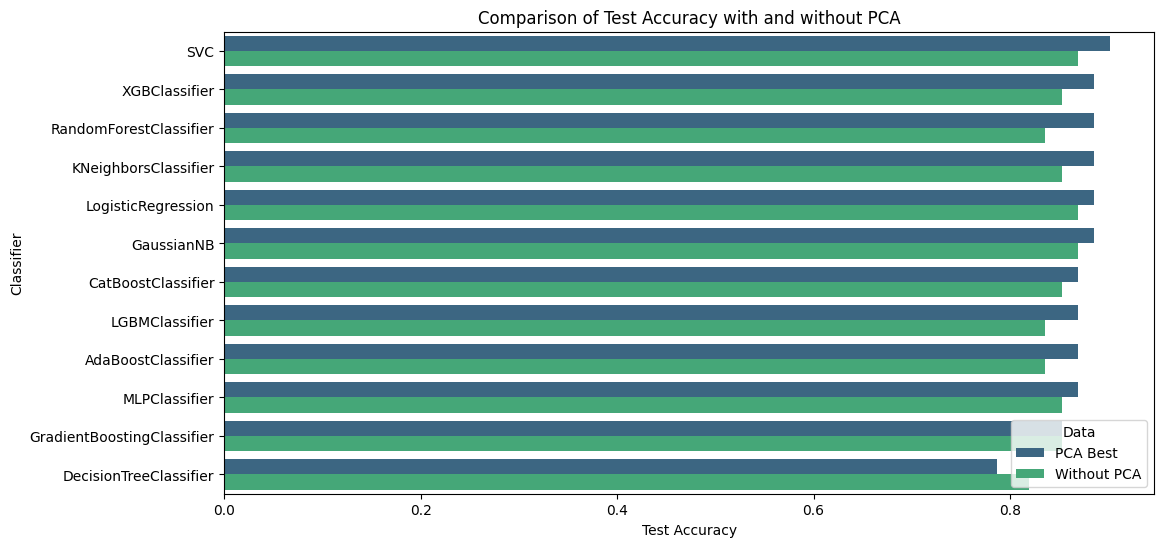

In [81]:
# Plot the accuracy scores for both PCA and Without PCA data
plt.figure(figsize=(12, 6))
sns.barplot(data=Performance_df, y='Classifier', x='Test_accuracy', hue='Data', palette='viridis')

# Set the title and labels
plt.title('Comparison of Test Accuracy with and without PCA')
plt.xlabel('Test Accuracy')
plt.ylabel('Classifier')

# Show the plot
plt.show()

### 6.5 Confusion matrix

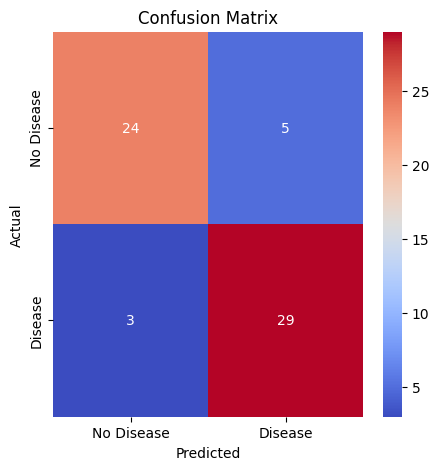

In [85]:
plot_confusion_matrix(confusion_matrixes['SVC_Without PCA'], ['No Disease', 'Disease'])

## 6.6 Integrating clustering with classification 

In [ ]:
Performance_df_new = pd.DataFrame(
    columns=[
        "Classifier",
        "Data",
        "Selected parameters",
        "CV score",
        "Train_accuracy",
        "Test_accuracy",
        "Train_precision",
        "Test_precision",
        "Train_recall",
        "Test_recall",
        "Train_f1",
        "Test_f1"
    ]
)
MODELS_NEW = []
confusion_matrixes_new = {}
for classifier_and_param_grid in CLASSIFIERS_AND_PARAM_GRIDS:
    for pre_processor_steps, description in PRE_PROCESSORS:
        print(f"Training {classifier_and_param_grid['classifier'].__class__.__name__} with {description}")
        model, performance, cm = train_and_validate_model(
            data=HEART_DATA_NEW,
            data_description=description,
            target_column=TARGET_COLUMN,
            pre_processor_steps=pre_processor_steps,
            classifier_and_params=classifier_and_param_grid,
            cluster=True
        )
        confusion_matrixes_new[classifier_and_param_grid['classifier'].__class__.__name__ + '_'+ description] = cm
        
        MODELS_NEW.append(model)
        Performance_df_new.loc[len(Performance_df_new)] = performance
        print("\n")


In [77]:
Performance_df_new.sort_values(by = 'Test_accuracy', ascending=False)

,Classifier,Data,Selected parameters,CV score,Train_accuracy,Test_accuracy,Train_precision,Test_precision,Train_recall,Test_recall,Train_f1,Test_f1
21,MLPClassifier,PCA Best,"{'classifier__activation': 'tanh', 'classifier...",-0.826446,0.826446,0.918033,0.827338,0.935484,0.864662,0.90625,0.845588,0.920635
3,SVC,PCA Best,"{'classifier__C': 0.01, 'classifier__degree': ...",-0.818112,0.809917,0.901639,0.800000,0.933333,0.872180,0.87500,0.834532,0.903226
23,GaussianNB,PCA Best,{'classifier__var_smoothing': 1e-09},-0.805782,0.814050,0.885246,0.818841,0.931034,0.849624,0.84375,0.833948,0.885246
1,LogisticRegression,PCA Best,"{'classifier__C': 0.1, 'classifier__penalty': ...",-0.834609,0.826446,0.885246,0.837037,0.931034,0.849624,0.84375,0.843284,0.885246
11,XGBClassifier,PCA Best,{'classifier__colsample_bytree': 0.80552577405...,-0.809949,0.917355,0.868852,0.900709,0.900000,0.954887,0.84375,0.927007,0.870968
4,RandomForestClassifier,Without PCA,"{'classifier__max_depth': 5, 'classifier__max_...",-0.834524,0.942149,0.868852,0.921986,0.852941,0.977444,0.90625,0.948905,0.878788
9,GradientBoostingClassifier,PCA Best,"{'classifier__learning_rate': 0.1, 'classifier...",-0.793537,1.000000,0.868852,1.000000,0.900000,1.000000,0.84375,1.000000,0.870968
20,MLPClassifier,Without PCA,"{'classifier__activation': 'relu', 'classifier...",-0.826190,1.000000,0.852459,1.000000,0.848485,1.000000,0.87500,1.000000,0.861538
19,KNeighborsClassifier,PCA Best,"{'classifier__n_neighbors': 7, 'classifier__p'...",-0.805952,0.818182,0.852459,0.824818,0.896552,0.849624,0.81250,0.837037,0.852459
15,CatBoostClassifier,PCA Best,"{'classifier__depth': 3, 'classifier__iteratio...",-0.814201,0.979339,0.852459,0.984848,0.896552,0.977444,0.81250,0.981132,0.852459
